In [53]:
import json
import copy
from typing import Optional, Callable, Tuple
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import seaborn as sns
sns.set()
from pathlib import Path
from PIL import Image
import cv2
from torchvision import transforms as T
import models
import data
import viz
import utils
from dim_reduction import LatentPCA
import latent_dp

EXP_NAME = "celeba_conv_cond/1645601750.1430178"

with open(f"./experiments/{EXP_NAME}/summary.json", 'r') as f:
    config = json.load(f)
Path(f"./experiments/{EXP_NAME}/eval").mkdir(exist_ok=True, parents=True)

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)

In [54]:
# Functions taken from: PyImageSearch URL

def anonymize_standard(x: torch.Tensor, 
                       anon_fn: Callable,
                       # anon_fn_kwargs: Dict[str, Any],
                       r: int,
                       c: int,
                       axes: Tuple[int, int]) -> np.ndarray:
    axes2 = tuple([i - 10 for i in axes])
    img_np = t_to_np(x[0])[...,::-1]
    img_np = cv2.cvtColor((255 * img_np).astype("uint8"), cv2.COLOR_RGB2BGR)

    img_anon = copy.copy(img_np)
    mask1 = cv2.ellipse(np.zeros_like(img_np), center=(c, r), axes=axes, angle=0, startAngle=0, endAngle=360, color=(255,255,255), thickness=-1)
    mask2 = cv2.ellipse(np.zeros_like(img_np), center=(c, r), axes=axes2, angle=0, startAngle=0, endAngle=360, color=(255,255,255), thickness=-1)

    face = np.bitwise_and(img_np, mask1)
    face_anon = anon_fn(face)
    img_anon[mask2.astype(bool)] = face_anon[mask2.astype(bool)]
    
    return img_anon

def anonymize_pixelate(x: torch.Tensor, 
                       r: int,
                       c: int,
                       axes: Tuple[int, int],
                       blocks: int = 3) -> np.ndarray:
    
    def _anonymize_pixelate(image: np.ndarray, blocks: int = 3) -> np.ndarray:
        # divide the input image into NxN blocks
        (h, w) = image.shape[:2]
        xSteps = np.linspace(0, w, blocks + 1, dtype="int")
        ySteps = np.linspace(0, h, blocks + 1, dtype="int")
        # loop over the blocks in both the x and y direction
        for i in range(1, len(ySteps)):
            for j in range(1, len(xSteps)):
                # compute the starting and ending (x, y)-coordinates
                # for the current block
                startX = xSteps[j - 1]
                startY = ySteps[i - 1]
                endX = xSteps[j]
                endY = ySteps[i]
                # extract the ROI using NumPy array slicing, compute the
                # mean of the ROI, and then draw a rectangle with the
                # mean RGB values over the ROI in the original image
                roi = image[startY:endY, startX:endX]
                (B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]
                cv2.rectangle(image, (startX, startY), (endX, endY),
                    (B, G, R), -1)
        # return the pixelated blurred image
        return image
    
    return anonymize_standard(x, lambda img: _anonymize_pixelate(img, blocks), r, c, axes)

def anonymize_blur(x: torch.Tensor, 
                   r: int,
                   c: int,
                   axes: Tuple[int, int],
                   factor: float = 3.) -> np.ndarray:
    
    def _anonymize_blur(image: np.ndarray, factor: float = 3.0) -> np.ndarray:
        # automatically determine the size of the blurring kernel based
        # on the spatial dimensions of the input image
        (h, w) = image.shape[:2]
        kW = int(w / factor)
        kH = int(h / factor)
        # ensure the width of the kernel is odd
        if kW % 2 == 0:
            kW -= 1
        # ensure the height of the kernel is odd
        if kH % 2 == 0:
            kH -= 1
        # apply a Gaussian blur to the input image using our computed
        # kernel size
        return cv2.GaussianBlur(image, (kW, kH), 0)
    
    return anonymize_standard(x, lambda img: _anonymize_blur(img, factor), r, c, axes)

def anonymize_noise(x: torch.Tensor, 
                    r: int,
                    c: int,
                    axes: Tuple[int, int],
                    sigma: float = 40.) -> np.ndarray:
    
    return anonymize_standard(x, lambda img: img + np.random.normal(0, sigma, img.shape), r, c, axes)

In [55]:
img_dims = getattr(data, f"{config['dataset']}_img_dims")
n_classes = getattr(data, f"{config['dataset']}_n_classes")
conditional = config["conditional"]
batch_size = 1 # config["batch_size"]

model = getattr(models, f"{config['model_name']}_model")(n_blocks_fc=config["n_blocks_fc"],
                                                         img_dims=img_dims,
                                                         n_classes=n_classes,
                                                         ica=config["ica"],
                                                         internal_width=config["internal_width"],
                                                         clamp=config["clamp"],
                                                         splits=config["splits"],
                                                         init_scale=config["init_scale"],
                                                         depths=config["depths"],
                                                         channels=config["channels"],
                                                         conditional=conditional,)
checkpoint = torch.load(f"./experiments/{EXP_NAME}/checkpoint.pt")
#try:
model.load_state_dict(checkpoint["model"])
#except RuntimeError:
#model.load_state_dict({'.'.join(key.split('.')[1:]): value for key, value in checkpoint["model"].items()}) 

<All keys matched successfully>

In [4]:
test_data = getattr(data, f"{config['dataset']}_test_data")(f"/mnt/ssd/data/{config['dataset']}")
data_loader  = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False, 
                                           num_workers=4, 
                                           pin_memory=True, 
                                           drop_last=True)
data_iter = iter(data_loader)
iter_ = 0

In [5]:
attrs = pd.read_csv("/mnt/ssd/data/celeba/list_attr_celeba.csv").columns[1:]
for i, attr in enumerate(attrs):
    print(f"{i}:\t{attr}")

0:	5_o_Clock_Shadow
1:	Arched_Eyebrows
2:	Attractive
3:	Bags_Under_Eyes
4:	Bald
5:	Bangs
6:	Big_Lips
7:	Big_Nose
8:	Black_Hair
9:	Blond_Hair
10:	Blurry
11:	Brown_Hair
12:	Bushy_Eyebrows
13:	Chubby
14:	Double_Chin
15:	Eyeglasses
16:	Goatee
17:	Gray_Hair
18:	Heavy_Makeup
19:	High_Cheekbones
20:	Male
21:	Mouth_Slightly_Open
22:	Mustache
23:	Narrow_Eyes
24:	No_Beard
25:	Oval_Face
26:	Pale_Skin
27:	Pointy_Nose
28:	Receding_Hairline
29:	Rosy_Cheeks
30:	Sideburns
31:	Smiling
32:	Straight_Hair
33:	Wavy_Hair
34:	Wearing_Earrings
35:	Wearing_Hat
36:	Wearing_Lipstick
37:	Wearing_Necklace
38:	Wearing_Necktie
39:	Young


In [175]:
attrs_not_altered = [20]

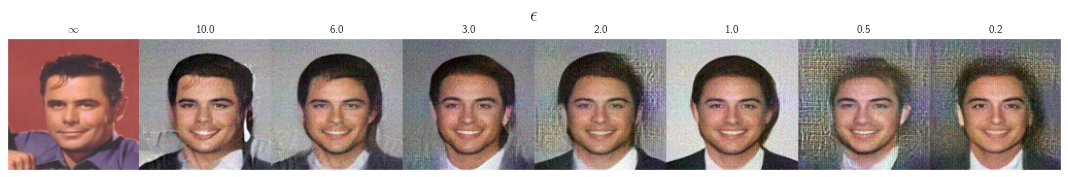

In [99]:
#x, y = next(data_iter)
x, y = test_data[18] # 50
x, y = x.cuda()[None], y.cuda()[None]
min_s = 4.0
epsilons = [10.0, 6.0, 3.0, 2.0, 1.0 , 0.5, 0.2]
laplace_dps = [latent_dp.LaplaceMechanism(epsilon=e, sensitivity=min(e/4, min_s)) for e in epsilons]
cond = data.make_cond(y, model.cond_sizes, batch_size, n_classes, multiclass=True)
with torch.no_grad():
    z, _ = model(x, cond)
    z_dps = [[laplace_dp( _z) for _z in z] for laplace_dp in laplace_dps]
    z = [torch.cat([_z, *[_z_dps[i] for _z_dps in z_dps]], dim=0) for i, _z in enumerate(z)]

    y_dp = torch.randint(2, y.size()).cuda().float()
    y_dp[...,attrs_not_altered] = y[...,attrs_not_altered]
    cond_dp = data.make_cond(y_dp, model.cond_sizes, batch_size, n_classes, multiclass=True)
    #cond_dp = cond
    cond_dp = [c.repeat(len(epsilons), *([1] *(len(c.shape) - 1))) for c in cond_dp]
    cond_dp = [torch.cat([c, cdp], dim=0) for c, cdp in zip(cond, cond_dp)]
    rev, _ = model(z, cond_dp, rev=True)
rev = rev.reshape(len(epsilons) + 1, 1, *img_dims)
epsilons = [r"$\infty$", *epsilons]
cols, rows = rev.shape[:2]
c, h, w = img_dims[-3:]
img_all = np.zeros((c, rows * img_dims[-2], cols * img_dims[-1]))
for i in range(rows):
    for j in range(cols):
        img_all[:, i*h:(i+1)*h,j*w:(j+1)*w] = rev[j,i].cpu().numpy()
        #cv2.imwrite(
        #    f"./experiments/{EXP_NAME}/eval/rec_e_{epsilons[i*rows + j]}.png",
        #    255 * np.clip(np.moveaxis(rev[j,i].cpu().numpy(), 0, -1)[...,::-1], 0, 1)
        #)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.clip(np.moveaxis(img_all, 0, -1), 0, 1))
# ax.set_xticks([])
ax.grid(False)
ax.set_xticks([h/2 + i * img_dims[-2] for i in range(len(epsilons))])
ax.set_xticklabels(epsilons)
ax.set_xlabel(r"$\epsilon$", fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_yticks([])
#ax.set_yticks([h/2 + i * img_dims[-1] for i in range(n_imgs)])
#ax.set_yticklabels(np.array(classes)[y.cpu().numpy()])
ax.tick_params(axis=u'both', which=u'both',length=0)

#ax.set_xlabel(r"$\mathrm{classes}$", fontsize=20)
plt.tight_layout()
#fig.savefig(f"./experiments/{EXP_NAME}/eval/epsilon_sweep2.pdf", bbox_inches="tight")
# i += 1

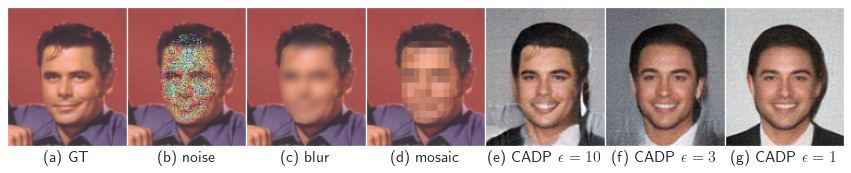

In [104]:
r = 65
c = 65
axes = (40,50)
# axes2 = (30,40)

t_to_np = lambda img: np.clip(np.moveaxis(img.cpu().detach().numpy(), 0, -1), 0, 1) 

x_np = t_to_np(x[0])
x_blur = anonymize_blur(x, r, c, axes, factor=6.)
x_pixelate = anonymize_pixelate(x, r, c, axes, blocks=20)
x_noisy = anonymize_noise(x, r, c, axes, sigma=40.)
x_cadp_eps10 = t_to_np(rev[1,0]) # eps = 10.0
x_cadp_eps3 = t_to_np(rev[3,0]) # eps = 3.0
x_cadp_eps1 = t_to_np(rev[5,0]) # eps = 1.0

fig, axs = plt.subplots(1,7, figsize=(15,5))

imgs = [x_np, x_noisy, x_blur, x_pixelate, x_cadp_eps10, x_cadp_eps3, x_cadp_eps1]
labels = ["(a) GT", "(b) noise", "(c) blur", "(d) mosaic", r"(e) CADP $\epsilon=10$", r"(f) CADP $\epsilon=3$", r"(g) CADP $\epsilon=1$"]
for img, ax, l in zip(imgs, axs, labels):
    img = cv2.resize(img, (110, 128))
    ax.imshow(np.clip(img, 0, 255))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlabel(l,fontsize=16)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig(f"./experiments/face_example8.pdf", bbox_inches="tight")

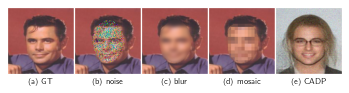

In [47]:
r = 65
c = 65
axes = (40,50)
# axes2 = (30,40)

t_to_np = lambda img: np.clip(np.moveaxis(img.cpu().detach().numpy(), 0, -1), 0, 1) 

x_np = t_to_np(x[0])
x_blur = anonymize_blur(x, r, c, axes, factor=6.)
x_pixelate = anonymize_pixelate(x, r, c, axes, blocks=20)
x_noisy = anonymize_noise(x, r, c, axes, sigma=40.)
x_cadp = t_to_np(rev[5,0]) # eps = 1.0

fig, axs = plt.subplots(1,5)

for img, ax, l in zip([x_np, x_noisy, x_blur, x_pixelate, x_cadp], axs, ["(a) GT", "(b) noise", "(c) blur", "(d) mosaic", "(e) CADP"]):
    img = cv2.resize(img, (128, 128))
    ax.imshow(np.clip(img, 0, 255))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlabel(l,fontsize=8)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
#fig.tight_layout()
fig.subplots_adjust(wspace=0., hspace=0)
fig.savefig(f"./experiments/face_example2.pdf", bbox_inches="tight")

In [7]:
data_iter = iter(data_loader)
i = 0

1 - B, 2 - E, 3 - D, 4 - A, 5 - C, 6 - G, 7 - F, 8 - H


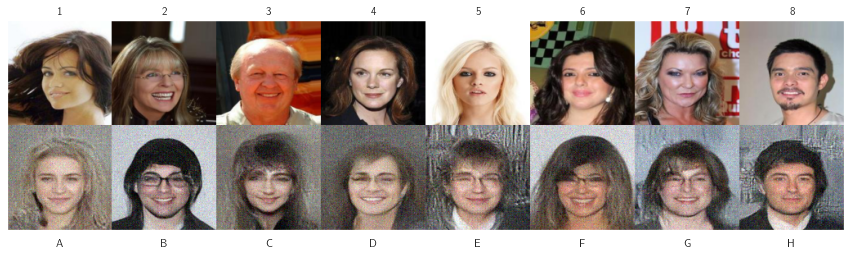

In [19]:
who_is_who = True
rows, cols = 2, 8
n_imgs = cols
# data_iter = iter(data_loader)
xy = [next(data_iter) for _ in range(n_imgs)]
x = torch.cat([_xy[0] for _xy in xy], dim=0).cuda()
y = torch.cat([_xy[1] for _xy in xy], dim=0).cuda()

laplace_dp = latent_dp.LaplaceMechanism(epsilon=1., sensitivity=0.4)
cond = data.make_cond(y, model.cond_sizes, batch_size, n_classes, multiclass=True)
with torch.no_grad():
    z, _ = model(x, cond)
    z_dp = [laplace_dp( _z) for _z in z]

    y_dp = torch.randint(2, y.size()).cuda().float()
    y_dp[...,attrs_not_altered] = y[...,attrs_not_altered]
    cond_dp = data.make_cond(y_dp, model.cond_sizes, batch_size, n_classes, multiclass=True) 
    rev_dp, _ = model(z_dp, cond_dp, rev=True)
if who_is_who:
    idx = torch.randperm(n_imgs)
    rev_dp = rev_dp[idx]
rev_dp = torch.cat([r for r in rev_dp], dim=-1).cpu().detach()
x = torch.cat([r for r in x], dim=-1).cpu().detach()
img = torch.cat([x, rev_dp], dim=-2)
fig, ax = plt.subplots(figsize=(15,15))
ax2 = ax.secondary_xaxis('top')
#ax2 = ax.twiny()
ax2.set_xticks([128/2 + i * 128 for i in range(8)])
ax2.set_xticklabels([i+1 for i in range(8)])
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax.imshow(np.clip(np.moveaxis(img.numpy(), 0, -1), 0, 1))
ax.set_xticks([128/2 + i * 128 for i in range(8)])
ax.set_xticklabels([*'ABCDEFGH'])
ax.set_yticks([])
ax.grid(False)
fig.savefig(f"./experiments/{EXP_NAME}/eval/samples{i}.pdf", bbox_inches="tight")
i += 1
print(', '.join([f'{i+1} - {"ABCDEFGH"[j]}' for i, j in enumerate(idx)]))

## Playground

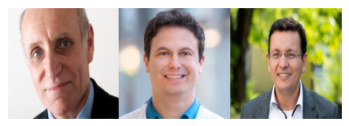

In [169]:
from PIL import Image

img_names = [
    "/home/malte/Downloads/katus.jpg", 
    "/home/malte/Downloads/meder2.jpeg", 
    "/home/malte/Downloads/heuveline.png"
]
imgs = [Image.open(fname) for fname in img_names]
imgs = [data.celeba_transform(x)[:3] for x in imgs]

cond_idxs = [
    [4, 17, 20, 24],
    [2, 11, 20, 19, 24, 31],
    [11, 15, 20, 24, 31]
]

plt.imshow(np.moveaxis(torch.cat(imgs, dim=-1).numpy(), 0, -1))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

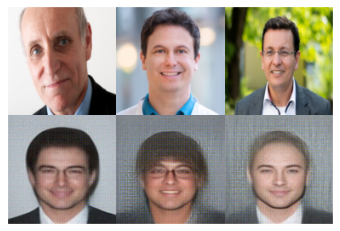

In [282]:
x = torch.stack(imgs).cuda()
cond = torch.zeros(x.size(0), 40).cuda()
for i, idxs in enumerate(cond_idxs):
    cond[i,idxs] = 1.
cond = data.make_cond(cond, model.cond_sizes, x.size(0), n_classes, multiclass=True)

s = 1.

laplace_dp = latent_dp.LaplaceMechanism(epsilon=10., sensitivity=s)
with torch.no_grad():
    z, _ = model(x, cond)
    z = laplace_dp(z)
    y_dp = torch.randint(2, (x.size(0), 40)).cuda().float()
    y_dp[...,attrs_not_altered] = 1
    cond_dp = data.make_cond(y_dp, model.cond_sizes, x.size(0), n_classes, multiclass=True) 
    rev, _ = model(z, cond_dp, rev=True)
rev_plot = torch.cat([r for r in rev], dim=-1).cpu().detach()
x_plot = torch.cat([r for r in x], dim=-1).cpu().detach()
img_plot = torch.cat([x_plot, rev_plot], dim=1)

fig, ax = plt.subplots()
ax.imshow(np.clip(np.moveaxis(img_plot.numpy(), 0, -1), 0, 1))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

t = T.ToPILImage()
for i, (r, img) in enumerate(zip(rev, x)):
    img, r = t(img), t(r)
    #if img_names[i].split('/')[-1].split('.')[0] == "katus":
    #    r.save(f"./images/{img_names[i].split('/')[-1].split('.')[0]}_cadp_{s}.png")
    #    print("here")
    #fig, ax = plt.subplots(figsize=(8,8))
    #ax.imshow(np.clip(np.moveaxis(r.cpu().numpy(), 0, -1), 0, 1))
    #fig.savefig(f"./images/{img_names[i].split('/')[-1].split('.')[0]}_{s}.png")
    
    #img.save(f"./images/{img_names[i].split('/')[-1].split('.')[0]}_{s}.png")
    #r.save(f"./images/{img_names[i].split('/')[-1].split('.')[0]}_cadp_{s}.png")

In [68]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

s = 0.2

sr = cv2.dnn_superres.DnnSuperResImpl_create()
path = "/home/malte/Downloads/EDSR_x2.pb"
sr.readModel(path)
sr.setModel("edsr",2)

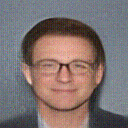

In [159]:
#img = np.array(Image.open(f"./images/{img_names[i].split('/')[-1].split('.')[0]}_cadp_{s}.png"))
img = np.array(Image.open(f"./images/heuveline_cadp_{s}.png"))
#img = cv2.fastNlMeansDenoisingColored(img, None, 5, 5, 7, 21)
#img = cv2.medianBlur(img, 3)


# meder heuveline
#img[(img[...,2] > 180) & (img[...,0] < 100)] = 0#[25,31,15]
#img[(img[...,1] > 230) & (img[...,2] < 100)] = 0#[25,31,15]
#img[(img[...,0] > 230) & (img[...,2] < 100)] = 0#[25,31,15]
# meder
img[(img[...,2] > 180) & (img[...,0] < 100)] = [25,31,15]
img[(img[...,1] > 230) & (img[...,2] < 100)] = [25,31,15]
img[(img[...,0] > 230) & (img[...,2] < 100)] = [25,31,15]
# katus meder
#img[(img[...,0] > 180) & (img[...,2] < 50)] = [25,31,15]
# katus
#img[(img[...,0] < 100) & (img[...,1] > 170)] = [184, 135, 118]
# heuveline
img[(img[...,0] < 100) & (img[...,1] > 150)] = [184, 135, 118]

#img = sr.upsample(img)
img_pil = Image.fromarray(img)

#img_pil.save("./images/heuveline_cadp.png")
img_pil

In [165]:
names = ["katus", "meder", "heuveline"]
imgs = [np.array(Image.open(f"./images/{name}_cadp.png")) for name in names]

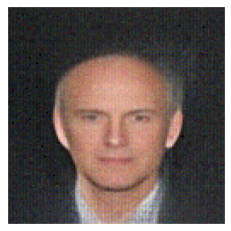

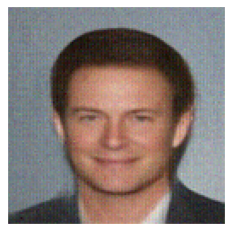

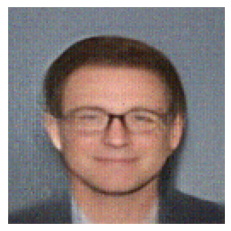

In [167]:
for name, img in zip(names, imgs):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    fig.savefig(f"./images/{name}_mpl.png", bbox_inches="tight", dpi=100)

In [172]:
res = T.Compose([T.Resize((322,322)),T.ToPILImage()])
for i, name in zip(imgs, names):
    i_res = res(i)
    i_res.save(f"./images/{name}_gt.png")
#i_res